
\cleardoublepage


### Variant: LSTM with 1 layer - shorter sequences




In [1]:
variant_codename = 'RenewedTiredRelaxed'

import sys
import yaml
sys.path.append('code')
from etl_hapt import get_Xy_data_sets
from pipelines import run_default_etl_pipeline, run_default_preprocessing_pipeline
from normalizer import fit_standard_scaler_to_sequence_batch, normalize_sequence_batch

yaml_config = \
"""
01_etl:
    data_set_dir: '/home/fabian/repositories/masterthesis_reloaded/data/HAPT Data Set'
    download_url: 'https://archive.ics.uci.edu/ml/machine-learning-databases/00341/HAPT%20Data%20Set.zip'
    data_split:
      train_participant_ids: [20,  6, 22, 18, 26, 27,  3, 11, 13, 30, 19, 12, 10, 17, 21,  4, 14, 24]
      test_participant_ids: [16, 28,  2,  1, 23, 25]
      validation_participant_ids: [ 7,  9, 15, 29,  8,  5]
    selected_labels: [1,2,3,4,5,6,7,8,9,10,11,12]
    channel_names_prior_preprocess: ['gyro-X', 'gyro-Y', 'gyro-Z', 'acc-X', 'acc-Y', 'acc-Z']
    channl_names_post_preprocess: ['gyro-X', 'gyro-Y', 'gyro-Z', 'body-X', 'body-Y', 'body-Z', 'gravity-X', 'gravity-Y', 'gravity-Z']
    sequence_length: 64
    sequence_stepsize: 32
    drop_columns: ['participant_id', 'experiment_id', 'time'] # the columns are loaded initially, because they are needed to sort and group data, but should not be used for modeling  
    group_column: 'experiment_id' # data is sequenced within these groups
02_preprocessing:
    sample_rate: 50
    median_filter_kernel: 3
    acc_columns_idx: [3,4,5] # indices of columns that contain the acceleration data
"""

yaml_config_model = \
"""
lstm_layer:
    units: 50
    activation: relu
    dropout: 0.0
    kernel_regularizer_l2: 0.001
    activity_regularizer_l1: 0.001
output_layer:
    activation: softmax
    kernel_regularizer_l2: 0.001
    activity_regularizer_l1: 0.001
loss: categorical_crossentropy
optimizer:
  adam:
    lr: 0.001
    beta_1: 0.9
    beta_2: 0.999
    decay: 0.0
metrics: ['accuracy']
epochs: 100
batch_size: 200
"""

%load_ext autoreload
%autoreload 2
config = yaml.load(yaml_config)
etl_config = config['01_etl']
preprocessing_config = config['02_preprocessing']
model_config = yaml.load(yaml_config_model)
df_Xy_train, df_Xy_test  = \
get_Xy_data_sets(
etl_config['data_set_dir'],
etl_config['download_url'],
ids_train=etl_config['data_split']['train_participant_ids'],
ids_test=etl_config['data_split']['test_participant_ids'],
)

X_train, y_train, y_train_binary = \
run_default_etl_pipeline(df_Xy_train, etl_config)

X_test, y_test, y_test_binary = \
run_default_etl_pipeline(df_Xy_test, etl_config)


X_train = run_default_preprocessing_pipeline(
X_train, preprocessing_config)
X_test = run_default_preprocessing_pipeline(
X_test, preprocessing_config)


means, variances = fit_standard_scaler_to_sequence_batch(X_train)
X_train = normalize_sequence_batch(X_train, means, variances)
X_test = normalize_sequence_batch(X_test, means, variances)



Xy shape:  (1122772, 10)
kept columns:  ['gyro-X' 'gyro-Y' 'gyro-Z' 'acc-X' 'acc-Y' 'acc-Z' 'activity_id']
Shape sequenced dataframe (now numpy array):  (21422, 64, 7)
kept columns:  ['gyro-X' 'gyro-Y' 'gyro-Z' 'acc-X' 'acc-Y' 'acc-Z' 'activity_id']
Shape sequenced dataframe (now numpy array):  (7349, 64, 7)


/home/fabian/.miniconda3/envs/masterthesis_tf_keras/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


Shape BEFORE separating acc and body:  (14121, 64, 6)
Shape AFTER separating acc and body:  (14121, 64, 9)
Shape BEFORE separating acc and body:  (4822, 64, 6)
Shape AFTER separating acc and body:  (4822, 64, 9)


In [2]:
import numpy as np
np.random.seed(2)
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
from keras import optimizers
from keras import regularizers
from keras import metrics
import pickle
import os
from plotting import plot_acc_loss_model_history, plot_multi_class_roc, set_mixed_color_linestyle_cycler

model_filepath = 'models/%s_model.h5' % variant_codename
history_filepath = 'models/%s_history.pickle' % variant_codename

# check if the model already exists. If yes the model and history can
# be loaded so the model does not have to be retrained for minor changes
# made in the document.
model_already_exists = os.path.isfile(model_filepath)
if model_already_exists:
    model = load_model(model_filepath)
    with open(history_filepath, 'rb') as handle:
        history = pickle.load(handle)
else:

    model = Sequential()
    model.add(LSTM(units=model_config['lstm_layer']['units'],
    input_shape=(X_train.shape[1], X_train.shape[2]),
    activation=model_config['lstm_layer']['activation'],
    dropout=model_config['lstm_layer']['dropout'],
    kernel_regularizer=regularizers.l2(model_config['lstm_layer']['kernel_regularizer_l2']),
    activity_regularizer=regularizers.l1(model_config['lstm_layer']['activity_regularizer_l1'])))

    model.add(Dense(y_train_binary.shape[1],
    activation=model_config['output_layer']['activation'],
    kernel_regularizer=regularizers.l2(model_config['output_layer']['kernel_regularizer_l2']),
    activity_regularizer=regularizers.l1(model_config['output_layer']['activity_regularizer_l1'])))
    adam_cfg = model_config['optimizer']['adam']
    opt = optimizers.Adam(lr=adam_cfg['lr'], beta_1=adam_cfg['beta_1'], beta_2=adam_cfg['beta_2'], epsilon=None, decay=adam_cfg['decay'], amsgrad=False)

    model.compile(loss=model_config['loss'], optimizer=opt, metrics=model_config['metrics'])


    history = model.fit(X_train, y_train_binary, validation_data=(X_test, y_test_binary), epochs=model_config['epochs'], batch_size=model_config['batch_size'], verbose=1)
    history = history.history
    # save model and history so the model does not have be retrained when updating the document
    model.save(model_filepath)
    with open(history_filepath, 'wb') as handle:
        pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)




Using TensorFlow backend.


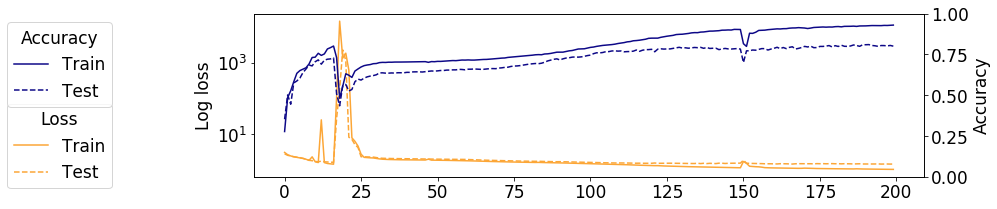

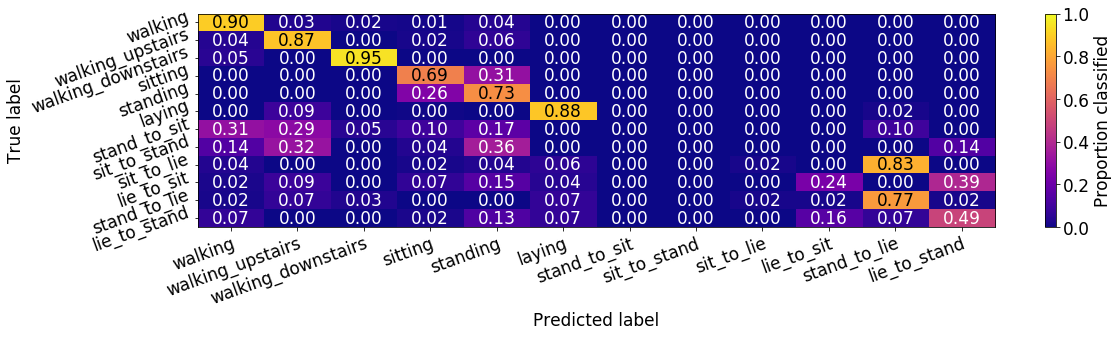

In [3]:

from plotting import plot_acc_loss_model_history_for_variant, plot_confusion_matrix_for_variant

plot_acc_loss_model_history_for_variant(history, variant_codename)
plot_confusion_matrix_for_variant(model, X_test, y_test, etl_config,

                                  variant_codename)



In [4]:
print(
"""
This variant uses a *sequence length* of *64* (instead of *128*) and a *sequence stepsize* of *32* (instead of *64*). This variant has an **accuracy of %.1f%%** on the test data set. See @fig:%s_confusion_matrix for how the model performs in classifying each label. See @fig:%s_learning_loss_accuracy for how the accuracy and loss evolved during training. The shorter sequence length and stepsize have a significant positive effect on the model's performance. However, transitions are still not being recognized well, some of them are not recognized at all. 
"""
% ((history['val_acc'][-1] * 100), variant_codename, variant_codename)
)





This variant uses a *sequence length* of *64* (instead of *128*) and a *sequence stepsize* of *32* (instead of *64*). This variant has an **accuracy of 80.1%** on the test data set. See @fig:RenewedTiredRelaxed_confusion_matrix for how the model performs in classifying each label. See @fig:RenewedTiredRelaxed_learning_loss_accuracy for how the accuracy and loss evolved during training. The shorter sequence length and stepsize have a significant positive effect on the model's performance. However, transitions are still not being recognized well, some of them are not recognized at all. 



In [5]:

print(
"""
![Confusion matrix of the predictions made by the model on the test set. The diagonal reflects the correctly classified proportions for each category.](figures/%s_confusion_matrix.png){#fig:%s_confusion_matrix}
"""
% (variant_codename, variant_codename)
)
print(
  """
  ![Accuracy and loss on train and test data sets during training of LSTM on the training data set.](figures/%s_learning_loss_accuracy.png){#fig:%s_learning_loss_accuracy}

  """
  % (variant_codename, variant_codename)
  )



![Confusion matrix of the predictions made by the model on the test set. The diagonal reflects the correctly classified proportions for each category.](figures/RenewedTiredRelaxed_confusion_matrix.png){#fig:RenewedTiredRelaxed_confusion_matrix}


  ![Accuracy and loss on train and test data sets during training of LSTM on the training data set.](figures/RenewedTiredRelaxed_learning_loss_accuracy.png){#fig:RenewedTiredRelaxed_learning_loss_accuracy}

  
